In [2]:
%matplotlib inline
import pandas as pd
from gensim import models, corpora
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation
from gensim.parsing.preprocessing import remove_stopwords, stem_text, strip_non_alphanum, strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_short, strip_numeric
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.phrases import Phrases, Phraser
import nltk
import numpy as np

In [3]:
topics_index_to_name_map = {
    0: 'Agriculture, animals, food and rural affairs',
    1: 'Asylum, immigration and nationality',
    2: 'Business, industry and consumers',
    3: 'Communities and families',
    4: 'Crime, civil law, justice and rights',
    5: 'Culture, media and sport',
    6: 'Defence',
    7: 'Economy and finance',
    8: 'Education',
    9: 'Employment and training',
    10: 'Energy and environment',
    11: 'European Union',
    12: 'Health services and medicine',
    13: 'Housing and planning',
    14: 'International affairs',
    15: 'Parliament, government and politics',
    16: 'Science and technology',
    17: 'Social security and pensions',
    18: 'Social services',
    19: 'Transport',
    20: 'admin',
    21: 'Others'
}
topics_name_to_index_map = {y:x for x,y in topics_index_to_name_map.items()}

def filter_multiple_topics(topic):
    if '|' in topic:
        return topic.split('|')[0].strip()
    return topic

def preprocess(topic):
    t = filter_multiple_topics(topic)
        
    return topics_name_to_index_map[t]

In [4]:
df = pd.read_csv('./data/2013_debate.csv')
#df = df.drop('date', axis=1)
df['topic'] = df.apply(lambda row: preprocess(row['topic']), axis=1)

In [5]:
df

,topic,transcript
0,4,1. What recent discussions she has had with t...
1,0,2. Whether her Department has taken steps to ...
2,21,3. What recent assessment she has made of tre...
3,1,4. What assessment her Department has made of...
4,11,5. If she will take steps to ensure that mail...
...,...,...
1968,20,8. What discussions the Commission had prior ...
1969,4,Before I call the Minister without Portfolio t...
1970,19,Before I call the Chair of the Transport Commi...
1971,20,"I beg to move, That this House has considered..."


In [6]:
df['topic'].value_counts()

15    270
4     248
12    147
14    144
7     112
2     102
6     100
3      96
9      95
8      92
19     91
21     87
10     87
5      82
20     72
0      46
11     32
1      30
13     19
16     10
17      7
18      4
Name: topic, dtype: int64

In [7]:
topic_doc = df.groupby('topic').agg({'transcript': ' '.join})

In [8]:
topic_doc

,transcript
topic,
0,2. Whether her Department has taken steps to ...
1,4. What assessment her Department has made of...
2,Before I call Mr Ian Swales to move the motion...
3,6. What assessment she has made of the effect...
4,1. What recent discussions she has had with t...
5,1. Whether she plans to reintroduce the gambl...
6,1. What recent assessment he has made of the ...
7,I am delighted to open this evening’s Adjournm...
8,11. How many student visa applications were r...


# Method1: TFIDF

In this tfidf method, we consider docs to be of topics and the term frequency and inverse term frequency is calculated considering one topic to be one doc.

In [9]:
docs = topic_doc['transcript'].values

In [10]:
def strip_short2(text):
    return strip_short(text, minsize=4)

def remove_custom_stopwords(s):
    my_stop_words = STOPWORDS.union(set(['time', 'year', 'number', 'today', 'week', 'month', 'night', 'world', 'home',
                                         'place', 'yesterday', 'life', 'wife']))
    return " ".join(w for w in s.split() if w not in my_stop_words)


def preprocess_text_for_tfidf(text):
    TFIDF_FILTERS = [lambda x: x.lower(), strip_multiple_whitespaces, strip_tags, strip_punctuation,
                   remove_custom_stopwords, strip_short2, strip_non_alphanum, strip_numeric]
    return preprocess_string(text, TFIDF_FILTERS)

def preprocess_text_for_tfidf2(text):
    TFIDF_FILTERS = [lambda x: x.lower(), strip_multiple_whitespaces, strip_tags, strip_punctuation,
                   remove_custom_stopwords, strip_short2, strip_non_alphanum, strip_numeric]
    return ' '.join(preprocess_string(text, TFIDF_FILTERS))

In [11]:
preprocessed_X = list(map(preprocess_text_for_tfidf, docs))

In [12]:
len(preprocessed_X[1])

58494

In [13]:
bigram_model = Phrases(preprocessed_X, min_count=1, threshold=0.5)

In [14]:
dictionary = corpora.Dictionary(bigram_model[preprocessed_X])
dictionary.filter_extremes(no_above=0.90, no_below=4)

In [15]:
len(dictionary.token2id)

65813

In [16]:
preprocessed_docs = bigram_model[preprocessed_X]
bow_X = list(map(dictionary.doc2bow, preprocessed_docs))

In [17]:
model = models.TfidfModel(bow_X)

In [18]:
tfidf_vector = model[bow_X]

In [19]:
from gensim import similarities
index = similarities.MatrixSimilarity(tfidf_vector)

In [20]:
sims = []

for i,s in enumerate(index):
    sims.append(s)

In [21]:
topics = ['Agriculture, animals, food and rural affairs', 
                            'Asylum, immigration and nationality', 
                            'Business, industry and consumers',
                            'Communities and families','Crime, civil law, justice and rights',
                            'Culture, media and sport',
                            'Defence','Economy and finance',
                            'Education','Employment and training',
                            'Energy and environment','European Union',
                            'Health services and medicine',
                            'Housing and planning',
                            'International affairs',
                            'Parliament, government and politics',
                            'Science and technology',
                            'Social security and pensions',
                            'Social services','Transport',
                            'admin',
                            'Others'
                           ]

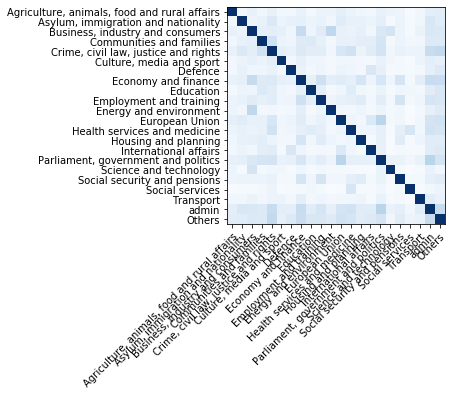

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

fig, ax = plt.subplots()
im = ax.imshow(sims,cmap=cm.Blues)

# We want to show all ticks...
ax.set_xticks(np.arange(len(topics)))
ax.set_yticks(np.arange(len(topics)))
# ... and label them with the respective list entries
ax.set_xticklabels(topics)
ax.set_yticklabels(topics)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


plt.savefig('./topic_similarity_debate.png',bbox_inches='tight')

In [24]:
for i in range(len(sims)):
    sims[i] = list(sims[i])

In [25]:
for i in range(len(sims)):
    sims[i] = [topics[i]] + sims[i]

In [26]:
columns = ['topic'] + topics

In [27]:
df2 = pd.DataFrame(sims, columns=columns)

In [28]:
df2

,topic,"Agriculture, animals, food and rural affairs","Asylum, immigration and nationality","Business, industry and consumers",Communities and families,"Crime, civil law, justice and rights","Culture, media and sport",Defence,Economy and finance,Education,...,Health services and medicine,Housing and planning,International affairs,"Parliament, government and politics",Science and technology,Social security and pensions,Social services,Transport,admin,Others
0,"Agriculture, animals, food and rural affairs",1.000000,0.042321,0.081900,0.042645,0.079619,0.038313,0.035834,0.077204,0.032502,...,0.061090,0.044681,0.033557,0.080096,0.068359,0.059230,0.015468,0.044297,0.106814,0.110329
1,"Asylum, immigration and nationality",0.042321,1.000000,0.063777,0.081844,0.147321,0.060667,0.085184,0.091399,0.065146,...,0.081817,0.085068,0.070979,0.095487,0.023316,0.060581,0.021562,0.047858,0.160442,0.122979
2,"Business, industry and consumers",0.081900,0.063777,1.000000,0.095726,0.103139,0.092030,0.055569,0.250899,0.059744,...,0.071754,0.088059,0.047964,0.156363,0.180703,0.061566,0.018285,0.074290,0.156085,0.147443
3,Communities and families,0.042645,0.081844,0.095726,1.000000,0.195679,0.063038,0.054771,0.132804,0.141532,...,0.083062,0.107650,0.103033,0.179608,0.029673,0.059850,0.038580,0.043005,0.142839,0.138485
4,"Crime, civil law, justice and rights",0.079619,0.147321,0.103139,0.195679,1.000000,0.096276,0.075373,0.137255,0.113772,...,0.197362,0.067863,0.118028,0.186320,0.046016,0.077251,0.067254,0.067313,0.243602,0.266382
5,"Culture, media and sport",0.038313,0.060667,0.092030,0.063038,0.096276,1.000000,0.038464,0.088651,0.049654,...,0.043004,0.035691,0.031341,0.076997,0.041520,0.027261,0.016819,0.061337,0.107097,0.087233
6,Defence,0.035834,0.085184,0.055569,0.054771,0.075373,0.038464,1.000000,0.076624,0.040266,...,0.054463,0.034803,0.157745,0.088024,0.020153,0.028850,0.021211,0.035027,0.096212,0.142792
7,Economy and finance,0.077204,0.091399,0.250899,0.132804,0.137255,0.088651,0.076624,1.000000,0.094300,...,0.097104,0.176681,0.059456,0.170532,0.050650,0.177106,0.030790,0.103064,0.244125,0.234081
8,Education,0.032502,0.065146,0.059744,0.141532,0.113772,0.049654,0.040266,0.094300,1.000000,...,0.122326,0.045404,0.032310,0.074692,0.024162,0.054556,0.045258,0.033430,0.118335,0.159445
9,Employment and training,0.067477,0.075427,0.119631,0.090883,0.116599,0.051706,0.059154,0.216689,0.098154,...,0.095468,0.121822,0.039605,0.110693,0.038640,0.186274,0.028231,0.052629,0.178267,0.157683


In [29]:
df2.to_csv('./similarities_debate.csv')

# Method 2: Modified TFIDF

In this specification, we consider both topics doc and articles doc. Term frequency is calculated for topics document whereas the inverse term frequency is calculated on the articles document.
i.e the score for any word in the vocabulary is given by:-

```score(w) = 
        number of times word appears in a topic * log2(total number of articles / number of articles this word appear in)```

In [30]:
df

,topic,transcript
0,4,1. What recent discussions she has had with t...
1,0,2. Whether her Department has taken steps to ...
2,21,3. What recent assessment she has made of tre...
3,1,4. What assessment her Department has made of...
4,11,5. If she will take steps to ensure that mail...
...,...,...
1968,20,8. What discussions the Commission had prior ...
1969,4,Before I call the Minister without Portfolio t...
1970,19,Before I call the Chair of the Transport Commi...
1971,20,"I beg to move, That this House has considered..."


In [31]:
topic_doc

,transcript
topic,
0,2. Whether her Department has taken steps to ...
1,4. What assessment her Department has made of...
2,Before I call Mr Ian Swales to move the motion...
3,6. What assessment she has made of the effect...
4,1. What recent discussions she has had with t...
5,1. Whether she plans to reintroduce the gambl...
6,1. What recent assessment he has made of the ...
7,I am delighted to open this evening’s Adjournm...
8,11. How many student visa applications were r...


In [32]:
topics_docs = topic_doc.transcript.values
articles = df.transcript.values

In [33]:
preprocessed_topic_docs = list(map(preprocess_text_for_tfidf, topics_docs))
preprocessed_articles = list(map(preprocess_text_for_tfidf, articles))

In [34]:
bigram_model = Phrases(preprocessed_articles, min_count=1, threshold=0.5)
dictionary = corpora.Dictionary(bigram_model[preprocessed_articles])
dictionary.filter_extremes(no_above=0.90, no_below=4)

In [35]:
words = list(dictionary.token2id.keys())
len(dictionary.token2id)

83942

In [36]:
preprocessed_topic_docs_with_bigrams = bigram_model[preprocessed_topic_docs]
preprocessed_articles_with_bigrams = bigram_model[preprocessed_articles]

In [37]:
preprocessed_articles_with_bigrams[0]

['recent_discussions',
 'mayor_london',
 'accessibility',
 'visibility',
 'metropolitan_police',
 'regularly_meet',
 'variously',
 'mayor_london',
 'deputy_mayor',
 'responsible_policing',
 'commissioner_metropolitan',
 'police',
 'government',
 'direct',
 'mayor_london',
 'metropolitan_police',
 'deploy_officers',
 'staff',
 'general_election',
 'police_officers',
 'london_fallen',
 'reported',
 'nearly_half',
 'capital',
 's',
 'police_stations',
 'face_closure',
 'secretary',
 'living_cloud',
 'cuckoo_land',
 'thinks',
 'improving_service',
 'londoners',
 'accept',
 'having_fewer',
 'police_fewer',
 'police_stations',
 'undermining_public',
 'confidence',
 'crucially',
 'undermining_ability',
 'needs_accept',
 'seen',
 'forces_england',
 'wales',
 'dealt',
 'budget_cuts',
 'seen_reductions',
 'police_officers',
 'crucially',
 'crime_falling',
 'visibility',
 'accessibility',
 'confidence_policing',
 'certain_types',
 'building',
 'police',
 'available_people',
 'exactly',
 'intends'

In [39]:
from collections import Counter
word_counter_articles = []
word_counter_topics = []

for i in range(1973):
    word_counter_articles.append(Counter(preprocessed_articles_with_bigrams[i]))

for i in range(22):
    word_counter_topics.append(Counter(preprocessed_topic_docs_with_bigrams[i]))

In [40]:
word_counter_topics[0]

Counter({'department_taken': 1,
         'steps_ensure': 1,
         'continuity_supply': 1,
         'seasonal_agricultural': 3,
         'workers': 50,
         'following': 11,
         'lifting_restrictions': 1,
         'immigration_bulgaria': 1,
         'romania': 9,
         'transitional_restrictions': 1,
         'bulgarians_romanians': 1,
         'come': 39,
         'reference_agricultural': 1,
         'industry_look': 1,
         'schemes_necessary': 1,
         'migration_advisory': 3,
         'committee_reported': 1,
         'march_minister': 2,
         'knows': 17,
         'finest': 3,
         'fruit_vegetables': 4,
         'grown': 7,
         'west_worcestershire': 2,
         'reassure_farmers': 1,
         'able': 30,
         'face_growing': 1,
         'picking': 3,
         'season': 4,
         'confidence_working': 1,
         'department_work': 2,
         'pensions_department': 1,
         'environment_food': 31,
         'rural_affairs': 33,
        

In [41]:
N = 1973

def precompute_idfs(words):
    idfs = {}
    for word in words:
        ni = 0
        for i in range(1973):
            if word in word_counter_articles[i]:
                ni = ni + 1
        idfs[word] = np.log2(N/ni)
        
    return idfs
idfs = precompute_idfs(dictionary.token2id.keys())

In [42]:
tfidf_vector = np.zeros((22, len(dictionary.token2id)))

In [43]:
for i in range(22):
    for j in range(len(words)):
        tfidf_vector[i][j] = word_counter_topics[i][words[j]] * idfs[words[j]]

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
sims = cosine_similarity(tfidf_vector, tfidf_vector)

In [45]:
sims[0]

array([1.        , 0.25021133, 0.33391168, 0.2829206 , 0.33601205,
       0.24778487, 0.22211302, 0.36093299, 0.22347271, 0.31599219,
       0.26787564, 0.3147592 , 0.29174698, 0.23248794, 0.23828808,
       0.33596908, 0.17404126, 0.2582502 , 0.14316572, 0.22649452,
       0.31332099, 0.39318104])

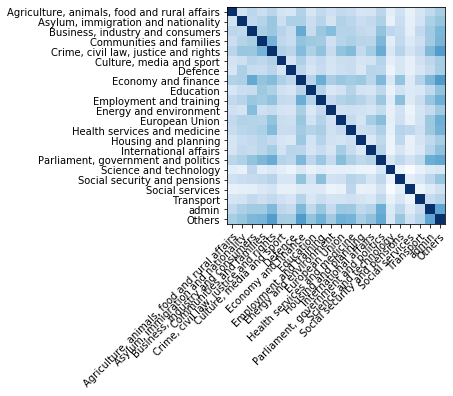

In [47]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

fig, ax = plt.subplots()
im = ax.imshow(sims,cmap=cm.Blues)

# We want to show all ticks...
ax.set_xticks(np.arange(len(topics)))
ax.set_yticks(np.arange(len(topics)))
# ... and label them with the respective list entries
ax.set_xticklabels(topics)
ax.set_yticklabels(topics)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


plt.savefig('./topic_similarity2_debate.png',bbox_inches='tight')

In [48]:
i = 0
rows = []
for i in range(len(sims)):
    rows.append([topics[i]] + list(sims[i]))
    
columns = ['topic'] + topics

df2 = pd.DataFrame(rows, columns=columns)
df2.to_csv('./similarities2_debate.csv')

In [49]:
df2

,topic,"Agriculture, animals, food and rural affairs","Asylum, immigration and nationality","Business, industry and consumers",Communities and families,"Crime, civil law, justice and rights","Culture, media and sport",Defence,Economy and finance,Education,...,Health services and medicine,Housing and planning,International affairs,"Parliament, government and politics",Science and technology,Social security and pensions,Social services,Transport,admin,Others
0,"Agriculture, animals, food and rural affairs",1.000000,0.250211,0.333912,0.282921,0.336012,0.247785,0.222113,0.360933,0.223473,...,0.291747,0.232488,0.238288,0.335969,0.174041,0.258250,0.143166,0.226495,0.313321,0.393181
1,"Asylum, immigration and nationality",0.250211,1.000000,0.319618,0.352859,0.433214,0.269792,0.380999,0.377334,0.283287,...,0.339699,0.289834,0.314303,0.373369,0.146459,0.280485,0.158277,0.243519,0.378181,0.437229
2,"Business, industry and consumers",0.333912,0.319618,1.000000,0.386755,0.426890,0.348268,0.294642,0.554080,0.293886,...,0.349966,0.316197,0.297853,0.445686,0.329848,0.304341,0.162303,0.314706,0.410899,0.496389
3,Communities and families,0.282921,0.352859,0.386755,1.000000,0.514947,0.324169,0.284175,0.445036,0.418623,...,0.378960,0.345462,0.337353,0.493888,0.175045,0.316166,0.202027,0.271629,0.407288,0.508084
4,"Crime, civil law, justice and rights",0.336012,0.433214,0.426890,0.514947,1.000000,0.367786,0.336246,0.477260,0.374152,...,0.481671,0.312002,0.403298,0.542978,0.209633,0.345686,0.237158,0.314800,0.487866,0.603337
5,"Culture, media and sport",0.247785,0.269792,0.348268,0.324169,0.367786,1.000000,0.236256,0.375228,0.259392,...,0.287486,0.230676,0.247485,0.353178,0.168229,0.221970,0.147838,0.259980,0.330552,0.399422
6,Defence,0.222113,0.380999,0.294642,0.284175,0.336246,0.236256,1.000000,0.328352,0.228530,...,0.285731,0.208312,0.344096,0.331606,0.130981,0.219203,0.148840,0.223564,0.301780,0.391505
7,Economy and finance,0.360933,0.377334,0.554080,0.445036,0.477260,0.375228,0.328352,1.000000,0.346064,...,0.403612,0.422380,0.336555,0.492948,0.207888,0.446373,0.192378,0.355807,0.492759,0.614350
8,Education,0.223473,0.283287,0.293886,0.418623,0.374152,0.259392,0.228530,0.346064,1.000000,...,0.355658,0.245215,0.229523,0.327711,0.136182,0.254929,0.200071,0.217673,0.316774,0.445456
9,Employment and training,0.315992,0.346703,0.428175,0.405874,0.449341,0.311009,0.298556,0.538250,0.350708,...,0.385489,0.352459,0.292454,0.425898,0.182383,0.462240,0.191948,0.283462,0.429185,0.526776
